In [1]:
import numpy as np
import sbi_tvb
from matplotlib import rcParams
from sbi_tvb.inference import TvbInference
from tvb.simulator.lab import *

/opt/conda/lib/python3.8/site-packages/tvb_library-2.2-py3.8.egg/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
rcParams['figure.figsize'] = 15, 6


In [3]:
#
# Simulation setup
#
dt = 0.005
nsigma = 0.035
seed = 42
sim_len = 30e3
G = 2.45
BOLD_TR = 2250

In [4]:
# Define connectivity
sbi_tvb_path = os.path.dirname(os.path.dirname(sbi_tvb.__file__))
weights = np.loadtxt(os.path.join(sbi_tvb_path, 'data_input_files', 'SC_Schaefer7NW100p_nolog10.txt'))

In [6]:
print("Build TvbInference object")
tvb_inference = TvbInference('results', num_simulations=10, num_workers=1)
tvb_inference

Build TvbInference object


In [7]:
print("Build prior")
tvb_inference.build_prior(1.5, 3.2)

Build prior


In [8]:
print("Simulation setup")
tvb_inference.simulation_setup_default(weights, sim_len, nsigma, BOLD_TR, dt, seed)

Simulation setup


In [9]:
print("Sbi inference")
tvb_inference.sbi_infer()

Sbi inference
FC_Corr
FC_Corr


/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow encountered in square
  s = s**2
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2487: Runti

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

FC_Corr


/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=w

FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
FC_Corr
WARNING  Found 1 NaN simulations and 1 Inf simulations. They will be excluded from training.


/opt/conda/lib/python3.8/site-packages/sbi-0.17.0-py3.8.egg/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 21 epochs.


DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: tensor([1.5000]), high: tensor([3.2000])), 1),
               x_shape=torch.Size([1, 1404]))
               

In [10]:
print("Run observed simulation")
BOLD_obs = tvb_inference.run_sim(G)

Run observed simulation


/opt/conda/lib/python3.8/site-packages/sbi-0.17.0-py3.8.egg/sbi/inference/posteriors/direct_posterior.py:333: UserWarning: You set `sample_with_mcmc=True`. This is deprecated since `sbi v0.17.0` and will lead to an error in future versions. Please use `sample_with='mcmc'` instead.
  warn(
Tuning bracket width...:   0%|          | 0/50 [00:00<?, ?it/s]

Posterior Distribution
FC_Corr


Generating samples: 100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


Plot G posterior


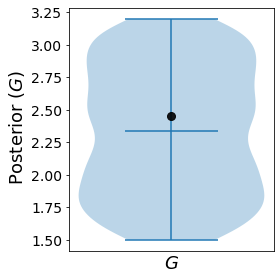

In [11]:
print("Posterior Distribution")
found_value = tvb_inference.posterior_distribution(BOLD_obs, G, True)

In [12]:
print("G value found: {}".format(found_value))

G value found: 2.3394737243652344
